# GATE: Sinogram, Primaries Only

The following example provides a complete example of a PET reconstruction from data generated from the GATE Monte Carlo program, including the computation of a normalization factor from a normalization scan. If you want to gain access to these files, please email me at `lukepolson@outlook.com`

In [1]:
import torch
import pytomography
from pytomography.projectors.PET import PETSinogramSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pytomography.metadata import ObjectMeta, PETSinogramPolygonProjMeta

In [2]:
# Change this
path = '/disk1/pet_mri_scan/'

In PyTomography, sinogram data can be obtained in two ways:

* (i) Using already opened listmode data (stored in `.npy` format)
* (ii) Directly from the ROOT files


## Data Loading

### Normalization Data

Option 1: Already saved listmode data (this was created in the listmode tutorial)

In [ ]:
# Macro used to create PET geometry in GATE
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Saved weights from listmode tutorial
weights_sensitivity = torch.load(os.path.join(path, 'norm_factor_lm.pt')).to(torch.float)
# Create and save normalization sinogram
norm_sinogram = gate.get_norm_sinogram_from_listmode_data(weights_sensitivity, macro_path)
torch.save(norm_sinogram, os.path.join(path, 'norm_sinogram.pt'))

Option 2: Directly from ROOT files

In [ ]:
# This cell only needs to be ran once and may take a while.
normalization_paths = [os.path.join(path, f'normalization_scan/mMR_Norm_{i}.root') for i in range(1,37)]
mean_interaction_depth = 9 # mm
cylinder_radius = 320 # mm (radius of calibration cylindrical shell)
macro_path = os.path.join(path, 'mMR_Geometry.mac')
norm_sinogram = gate.get_norm_sinogram_from_root_data(
    normalization_paths,
    macro_path,
    cylinder_radius=cylinder_radius,
    include_randoms=False, #used to ignore random events in simulation
    mean_interaction_depth=mean_interaction_depth)
torch.save(norm_sinogram, os.path.join(path, 'norm_sinogram.pt'))

Once the either of the cells above has been ran once, the data can be easily loaded as follows:

In [3]:
norm_sinogram = torch.load(os.path.join(path, 'norm_sinogram.pt'))

### Sinogram Data

Option 1: Already saved listmode data (this was created in the listmode tutorial)

In [ ]:
detector_ids = torch.tensor(np.load(os.path.join(path, 'detector_ids.npy')))
sinogram = gate.get_sinogram_from_listmode_data(detector_ids, macro_path)
torch.save(sinogram, os.path.join(path, 'sinogram.pt'))

Option2: Directly from ROOT files

In [ ]:
# Get detector IDs from GATE file
paths = [os.path.join(path, f'gate_simulation/no_atten/f{i}.root') for i in range(1, 19)]
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Note: currently sinogram PET reconstruction does not support time of flight, though this will likely change in the near future
sinogram = gate.get_sinogram_from_root_data(paths, macro_path, include_randoms=False)
torch.save(sinogram, os.path.join(path, 'sinogram.pt'))

Once either of the cells has been ran once, the data can be loaded as follows:

In [4]:
sinogram = torch.load(os.path.join(path, 'sinogram.pt'))

## Reconstruction

Unlike with listmode data, we can actually view data from the sinogram. Lets first examine the shape

In [5]:
sinogram.shape

torch.Size([224, 449, 4096])

The data is stored such that the first dimension corresponds to $r$, the second to $\theta$, and the third to the oblique planes. The oblique planes are corresponding to the following ring differences $+0$, $-1$, $+1$, $-2$, $+2$. Since we have 64 rings, we can look at a projection corresponding to $\theta=0$ with ring differences equal to $+0$ as follows:

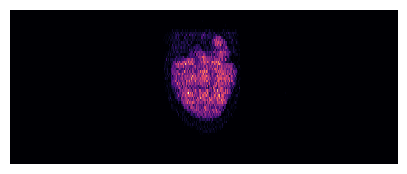

In [6]:
plt.figure(figsize=(5,2))
plt.pcolormesh(sinogram[0,:,:64].T, cmap='magma')
plt.axis('off')
plt.show()

We can obtain our projection metadata by loading the appropriate scanner info. The `info` is intended to be modality independent (gate/petsird/vendor format) and thus we load it first before creating the projection metadata

In [7]:
macro_path = os.path.join(path, 'mMR_Geometry.mac') 
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
proj_meta = PETSinogramPolygonProjMeta(info)

From this we define our object meta (dimensions of our reconstructed image) and our system matrix. We use the `norm_sinogram` as an input argument to this system matrix

In [8]:
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)

In [9]:
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       norm_sinogram = norm_sinogram,
       N_splits=10,
)

/data/home/gpuvmadm/PyTomography/src/pytomography/projectors/PET/pet_sinogram_system_matrix.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xy1 = torch.flatten(torch.tensor(self.proj_meta.detector_coordinates), start_dim=0, end_dim=1)[:,0].cpu()
/data/home/gpuvmadm/PyTomography/src/pytomography/projectors/PET/pet_sinogram_system_matrix.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xy2 = torch.flatten(torch.tensor(self.proj_meta.detector_coordinates), start_dim=0, end_dim=1)[:,1].cpu()
/data/home/gpuvmadm/PyTomography/src/pytomography/projectors/PET/pet_sinogram_system_matrix.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().det

Then, as usual, we define our likelihood and reconstruction algorithm:

In [10]:
likelihood = PoissonLogLikelihood(system_matrix, sinogram.to(pytomography.device))
recon_algorithm = OSEM(likelihood)
recon = recon_algorithm(2,28)

And we can plot our reconstruction:

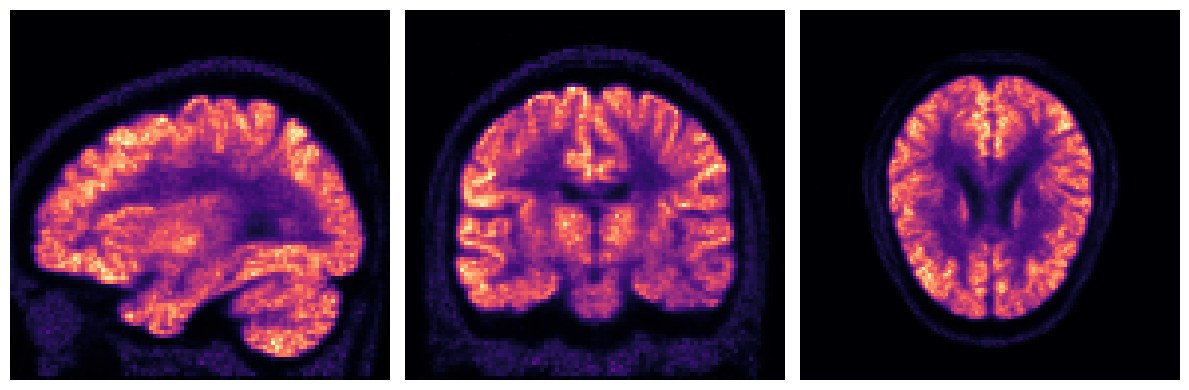

In [11]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon[0,48,16:-16].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon[0,16:-16,64].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon[0,:,:,48].cpu().T, cmap='magma')
plt.axis('off')
fig.tight_layout()
plt.show()

*Note: This consists of far more data then obtained in a real clinical PET scan so the image looks very good*